In [221]:
%matplotlib inline

import jax
import jumanji
from jumanji.wrappers import AutoResetWrapper
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import pickle

## RL FUNCTIONS

In [266]:
def state_to_index(x, y, columns):
        return x * columns + y

def index_to_state(idx, columns):
    x = idx // columns
    y = idx % columns
    return x, y

def generate_transition_matrix_maze(walls):
    rows = walls.shape[0]  # Number of rows
    columns = walls.shape[1]  # Number of columns
    num_states = rows * columns
    num_actions = 4  # up, right, down, left

    # Transition matrix P(s'|s,a)
    P = np.zeros((num_states, num_states, num_actions))

    # Actions: up (0), right (1), down (2), left (3)
    actions = {
        0: (-1, 0),  # Up
        1: (0, 1),   # Right
        2: (1, 0),   # Down
        3: (0, -1)   # Left
    }

    # Populate the transition matrix
    for x in range(rows):
        for y in range(columns):
            current_state = state_to_index(x, y, columns)
            for action, (dx, dy) in actions.items():
                new_x, new_y = x + dx, y + dy
                if 0 <= new_x < rows and 0 <= new_y < columns and not walls[new_x, new_y]:
                    next_state = state_to_index(new_x, new_y, columns)
                else:
                    next_state = current_state  # Stay in place on wall or out-of-bounds
                
                P[next_state, current_state, action] = 1

    return P

def generate_reward_function_maze(target_position, walls):
    rows = walls.shape[0]  # Number of rows
    columns = walls.shape[1]  # Number of columns
    num_states = rows * columns
    num_actions = 4  # up, right, down, left
    rewards = np.zeros(rows * columns)
    target_index = state_to_index(target_position[0], target_position[1], columns)
    rewards[target_index] = 1
    return rewards

def value_iteration(P, reward, discount, precision=1e-5):
    state_size = P.shape[0]
    action_size = P.shape[2]
    value = np.zeros(state_size)
    prev_value = np.ones(state_size)
    pi_vi = np.zeros((action_size, state_size))
    # while (np.abs(value - prev_value) > precision).all():
    while np.max(np.abs(value - prev_value)) > precision:
        prev_value = value.copy()
        for state in range(state_size):
            value[state] = np.max(
                [
                    reward[state] + discount * np.sum(P[:, state, action] * value)
                    for action in range(action_size)
                ]
            )

    for state in range(state_size):
        values = np.array(
            [
                reward[state] + discount * np.sum(P[:, state, action] * value)
                for action in range(action_size)
            ]
        )
        # values = np.round(values, decimals=5)
        # maximum = np.max(values)
        # indices = np.argwhere(values == maximum).flatten()

        # chosen_index = np.random.choice(indices)
        # pi_vi[chosen_index, state] = 1

        # pi_vi[indices, state] = 1/(len(indices))

        best_action = np.argmax([reward[state] + discount * np.sum(P[:,state,action] * value) for action in range(action_size)])
        pi_vi[best_action, state] = 1

    return pi_vi, value

def plot_policy(policy, grid, title):
    n, m = grid.shape
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(grid, cmap='gray')

    for i in range(n):
        for j in range(m):
            if grid[i, j]:
                continue  # Skip walls
            state = i * m + j
            if policy[0, state] > 0:  # Up
                # print("up")
                ax.arrow(j, i, 0, -0.5, head_width=0.2, head_length=0.2, fc='red', ec='red')
            if policy[1, state] > 0:  # Right
                ax.arrow(j, i, 0.5, 0, head_width=0.2, head_length=0.2, fc='green', ec='green')
                # print("right")
            if policy[2, state] > 0:  # Down
                ax.arrow(j, i, 0, 0.5, head_width=0.2, head_length=0.2, fc='blue', ec='blue')
                # print("down")
            if policy[3, state] > 0:  # Left
                # print("left")
                ax.arrow(j, i, -0.5, 0, head_width=0.2, head_length=0.2, fc='yellow', ec='yellow')
    
    ax.set_xticks(np.arange(-0.5, m, 1))
    ax.set_yticks(np.arange(-0.5, n, 1))
    plt.savefig(title)


def plot_value_function(value, grid, title):
    n, m = grid.shape
    reshaped_value = value.reshape(n, m)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    # Create a heatmap for the value function
    cax = ax.matshow(reshaped_value, cmap='viridis')
    
    # Overlay the grid layout to identify walls
    for i in range(n):
        for j in range(m):
            if grid[i, j] == 1:  # Assuming 1 indicates a wall
                ax.text(j, i, 'W', va='center', ha='center', color='white', fontsize=12)
            else:
                ax.text(j, i, f'{reshaped_value[i, j]:.2f}', va='center', ha='center', color='white', fontsize=8)
    
    # Set up the axis
    ax.set_xticks(np.arange(-0.5, m, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, n, 1), minor=True)
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
    ax.set_xticks(np.arange(m))
    ax.set_yticks(np.arange(n))
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    fig.colorbar(cax)
    plt.savefig(title)

In [267]:
env = jumanji.make("Maze-v0")  # Create a Snake environment
# env = AutoResetWrapper(env)     # Automatically reset the environment when an episode terminates

In [268]:
batch_size = 5
rollout_length = 20
num_actions = env.action_spec.num_values

In [269]:
from jumanji.environments.routing.maze.types import Position, State

random_key = jax.random.PRNGKey(1)
key1, key2, key3 = jax.random.split(random_key, 3)

def sample_state(state, key):
  rows = state.walls.shape[0]
  cols = rows = state.walls.shape[1]
  state_indices = jax.random.choice(key, jnp.arange(rows * cols), (1,), p=~state.walls.flatten())
  (state_row, state_col) = jnp.divmod(state_indices, env.num_cols)
  sampled_position = Position(row = state_row[0], col = state_col[0])
  state.agent_position = sampled_position

  actions = [(-1, 0), (0, 1), (1, 0), (0, -1)]  # Up, Right, Down, Left

  action_mask = jnp.array([
      jnp.all(jnp.array([
          0 <= state.agent_position.row + dr,
          state.agent_position.row + dr < rows,
          0 <= state.agent_position.col + dc,
          state.agent_position.col + dc < cols,
          ~state.walls[state.agent_position.row + dr, state.agent_position.col + dc]
      ]))
      for dr, dc in actions
  ], dtype=bool)

  state.action_mask = action_mask

  return state

def step_fn(state, key):
  action = jax.random.randint(key=key, minval=0, maxval=num_actions, shape=())
  new_state, timestep = env.step(state, action)
  return new_state, {
                      "state": [state.agent_position],
                      "action": action, 
                      "next_state": [new_state.agent_position],
                      "reward": timestep.reward,
                      "whole_timestep": timestep
                    }

def uniform_step_fn(state, key):
  key_action, key_state = jax.random.split(key)
  state = sample_state(state, key_state)
  return step_fn(state, key_action)

def run_n_steps(state, key, n):
  random_keys = jax.random.split(key, n)
  state, rollout = jax.lax.scan(uniform_step_fn, state, random_keys)
  return rollout

# Instantiate a batch of environment states
keys_init = jax.random.split(key1, batch_size)
# keys_init = jnp.tile(key1, (batch_size, 1))
state, timestep = jax.vmap(env.reset)(keys_init)

# Collect a batch of rollouts
keys_rollout = jax.random.split(key2, batch_size)
rollout = jax.vmap(run_n_steps, in_axes=(0, 0, None))(state, keys_rollout, rollout_length)
print(state)

State(agent_position=Position(row=Array([8, 1, 8, 0, 1], dtype=int32), col=Array([4, 4, 8, 7, 8], dtype=int32)), target_position=Position(row=Array([2, 9, 3, 0, 8], dtype=int32), col=Array([2, 6, 8, 2, 1], dtype=int32)), walls=Array([[[False, False, False, False, False, False, False, False, False,
          True],
        [ True,  True,  True,  True,  True,  True,  True,  True, False,
          True],
        [False,  True, False, False, False, False, False, False, False,
          True],
        [False,  True,  True,  True,  True,  True,  True,  True, False,
          True],
        [False,  True, False, False, False, False, False,  True, False,
         False],
        [False,  True,  True,  True,  True,  True, False,  True, False,
          True],
        [False,  True, False, False, False,  True, False,  True, False,
          True],
        [False,  True,  True,  True, False,  True, False,  True, False,
          True],
        [False, False, False, False, False, False, False, Fal

In [286]:
state.walls[0]

key = jax.random.PRNGKey(0)

false_indices = jnp.argwhere(state.walls[0] == False)

shuffled_indices = jax.random.permutation(key, false_indices, axis=0)

# Calculate the split index for 70% training, 30% testing
split_index = int(0.8 * len(shuffled_indices))

# Split the indices
training_indices = shuffled_indices[:split_index]
testing_indices = shuffled_indices[split_index:]

In [344]:
state.target_position.col

Array([2, 6, 8, 2, 1], dtype=int32)

In [341]:
rows = 10
cols = 10
target_row = state.target_position.row[0]
target_col = state.target_position.col[0]

# Define the range of rows and columns around the target
row_indices = jnp.arange(max(0, target_row - 2), min(rows, target_row + 3))
col_indices = jnp.arange(max(0, target_col - 2), min(cols, target_col + 3))

# Create a mask to select only the positions within the specified range
mask = jnp.zeros_like(state.walls[0], dtype=bool).at[row_indices[:, None], col_indices].set(True)
new_mask = ~(mask | state.walls[0])

In [343]:
state

State(agent_position=Position(row=Array([8, 1, 8, 0, 1], dtype=int32), col=Array([4, 4, 8, 7, 8], dtype=int32)), target_position=Position(row=Array([2, 9, 3, 0, 8], dtype=int32), col=Array([2, 6, 8, 2, 1], dtype=int32)), walls=Array([[[False, False, False, False, False, False, False, False, False,
          True],
        [ True,  True,  True,  True,  True,  True,  True,  True, False,
          True],
        [False,  True, False, False, False, False, False, False, False,
          True],
        [False,  True,  True,  True,  True,  True,  True,  True, False,
          True],
        [False,  True, False, False, False, False, False,  True, False,
         False],
        [False,  True,  True,  True,  True,  True, False,  True, False,
          True],
        [False,  True, False, False, False,  True, False,  True, False,
          True],
        [False,  True,  True,  True, False,  True, False,  True, False,
          True],
        [False, False, False, False, False, False, False, Fal

In [342]:
target_row, target_col, row_indices, col_indices, mask, new_mask

(Array(2, dtype=int32),
 Array(2, dtype=int32),
 Array([0, 1, 2, 3, 4], dtype=int32),
 Array([0, 1, 2, 3, 4], dtype=int32),
 Array([[ True,  True,  True,  True,  True, False, False, False, False,
         False],
        [ True,  True,  True,  True,  True, False, False, False, False,
         False],
        [ True,  True,  True,  True,  True, False, False, False, False,
         False],
        [ True,  True,  True,  True,  True, False, False, False, False,
         False],
        [ True,  True,  True,  True,  True, False, False, False, False,
         False],
        [False, False, False, False, False, False, False, False, False,
         False],
        [False, False, False, False, False, False, False, False, False,
         False],
        [False, False, False, False, False, False, False, False, False,
         False],
        [False, False, False, False, False, False, False, False, False,
         False],
        [False, False, False, False, False, False, False, False, False,
   

In [330]:
mask

Array([[ True,  True,  True,  True,  True, False, False, False, False,
        False],
       [ True,  True,  True,  True,  True, False, False, False, False,
        False],
       [ True,  True,  True,  True,  True, False, False, False, False,
        False],
       [ True,  True,  True,  True,  True, False, False, False, False,
        False],
       [ True,  True,  True,  True,  True, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False]], dtype=bool)

In [292]:
target_col, target_row

(Array(2, dtype=int32), Array(2, dtype=int32))

In [293]:
mask

Array([[[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         False],
        [False, False, False, False, False, False, False, False,  True,
         False],
        [ True, False,  True,  True,  True,  True,  True,  True,  True,
         False],
        [ True, False, False, False, False, False, False, False,  True,
         False],
        [ True, False,  True,  True,  True,  True,  True, False,  True,
          True],
        [ True, False, False, False, False, False,  True, False,  True,
         False],
        [False, False, False, False, False, False, False, False, False,
         False],
        [False, False, False, False, False, False, False, False, False,
         False],
        [False, False, False, False, False, False, False, False, False,
         False],
        [False, False, False, False, False, False, False, False, False,
         False]],

       [[ True,  True,  True, False,  True, False,  True, False,  True,
         False],
        [ True, Fal

In [287]:
len(training_indices), len(testing_indices)

(44, 11)

In [270]:
print(timestep)

TimeStep(step_type=Array([0, 0, 0, 0, 0], dtype=int8), reward=Array([0., 0., 0., 0., 0.], dtype=float32), discount=Array([1., 1., 1., 1., 1.], dtype=float32), observation=Observation(agent_position=Position(row=Array([8, 1, 8, 0, 1], dtype=int32), col=Array([4, 4, 8, 7, 8], dtype=int32)), target_position=Position(row=Array([2, 9, 3, 0, 8], dtype=int32), col=Array([2, 6, 8, 2, 1], dtype=int32)), walls=Array([[[False, False, False, False, False, False, False, False, False,
          True],
        [ True,  True,  True,  True,  True,  True,  True,  True, False,
          True],
        [False,  True, False, False, False, False, False, False, False,
          True],
        [False,  True,  True,  True,  True,  True,  True,  True, False,
          True],
        [False,  True, False, False, False, False, False,  True, False,
         False],
        [False,  True,  True,  True,  True,  True, False,  True, False,
          True],
        [False,  True, False, False, False,  True, False,  Tru

In [271]:
print(state)

State(agent_position=Position(row=Array([8, 1, 8, 0, 1], dtype=int32), col=Array([4, 4, 8, 7, 8], dtype=int32)), target_position=Position(row=Array([2, 9, 3, 0, 8], dtype=int32), col=Array([2, 6, 8, 2, 1], dtype=int32)), walls=Array([[[False, False, False, False, False, False, False, False, False,
          True],
        [ True,  True,  True,  True,  True,  True,  True,  True, False,
          True],
        [False,  True, False, False, False, False, False, False, False,
          True],
        [False,  True,  True,  True,  True,  True,  True,  True, False,
          True],
        [False,  True, False, False, False, False, False,  True, False,
         False],
        [False,  True,  True,  True,  True,  True, False,  True, False,
          True],
        [False,  True, False, False, False,  True, False,  True, False,
          True],
        [False,  True,  True,  True, False,  True, False,  True, False,
          True],
        [False, False, False, False, False, False, False, Fal

In [272]:
state

State(agent_position=Position(row=Array([8, 1, 8, 0, 1], dtype=int32), col=Array([4, 4, 8, 7, 8], dtype=int32)), target_position=Position(row=Array([2, 9, 3, 0, 8], dtype=int32), col=Array([2, 6, 8, 2, 1], dtype=int32)), walls=Array([[[False, False, False, False, False, False, False, False, False,
          True],
        [ True,  True,  True,  True,  True,  True,  True,  True, False,
          True],
        [False,  True, False, False, False, False, False, False, False,
          True],
        [False,  True,  True,  True,  True,  True,  True,  True, False,
          True],
        [False,  True, False, False, False, False, False,  True, False,
         False],
        [False,  True,  True,  True,  True,  True, False,  True, False,
          True],
        [False,  True, False, False, False,  True, False,  True, False,
          True],
        [False,  True,  True,  True, False,  True, False,  True, False,
          True],
        [False, False, False, False, False, False, False, Fal

In [273]:
print(rollout)

{'action': Array([[3, 2, 2, 3, 1, 3, 0, 1, 2, 1, 3, 1, 1, 1, 0, 3, 3, 3, 0, 0],
       [1, 0, 1, 3, 2, 1, 1, 1, 3, 3, 3, 0, 1, 2, 2, 3, 0, 0, 3, 2],
       [2, 3, 3, 2, 3, 1, 3, 0, 3, 3, 1, 0, 2, 2, 3, 0, 0, 3, 1, 1],
       [0, 3, 3, 2, 0, 2, 2, 2, 0, 3, 2, 1, 0, 0, 0, 3, 2, 0, 1, 1],
       [1, 1, 2, 3, 3, 0, 0, 0, 0, 3, 2, 2, 1, 2, 1, 1, 2, 0, 1, 1]],      dtype=int32), 'next_state': [Position(row=Array([[9, 1, 8, 0, 4, 6, 2, 4, 8, 1, 4, 5, 2, 8, 2, 5, 8, 9, 4, 4],
       [4, 5, 2, 9, 8, 8, 4, 8, 5, 9, 2, 7, 7, 8, 5, 8, 8, 1, 4, 2],
       [2, 5, 6, 8, 2, 2, 8, 0, 3, 0, 2, 4, 6, 1, 6, 0, 6, 4, 4, 6],
       [0, 2, 6, 1, 4, 2, 4, 7, 5, 0, 8, 8, 4, 4, 0, 8, 7, 2, 9, 5],
       [4, 2, 0, 2, 0, 6, 0, 8, 2, 4, 9, 4, 5, 6, 4, 4, 8, 4, 5, 4]],      dtype=int32), col=Array([[2, 8, 8, 3, 6, 6, 3, 9, 4, 8, 8, 0, 5, 6, 6, 8, 7, 0, 3, 5],
       [7, 0, 4, 0, 8, 3, 7, 7, 6, 2, 2, 0, 8, 6, 4, 0, 3, 6, 3, 0],
       [2, 8, 8, 1, 0, 8, 6, 0, 6, 3, 8, 2, 2, 4, 8, 2, 8, 0, 7, 4],
       [8, 4, 4, 0, 

[2 2]
[9 6]
[3 8]
[0 2]
[8 1]


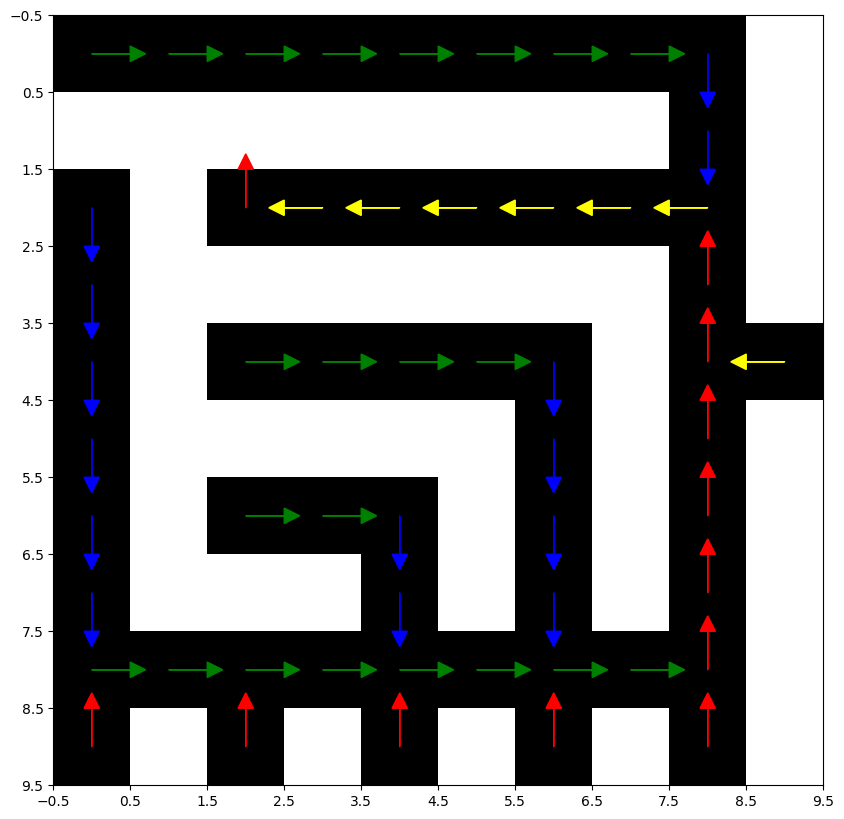

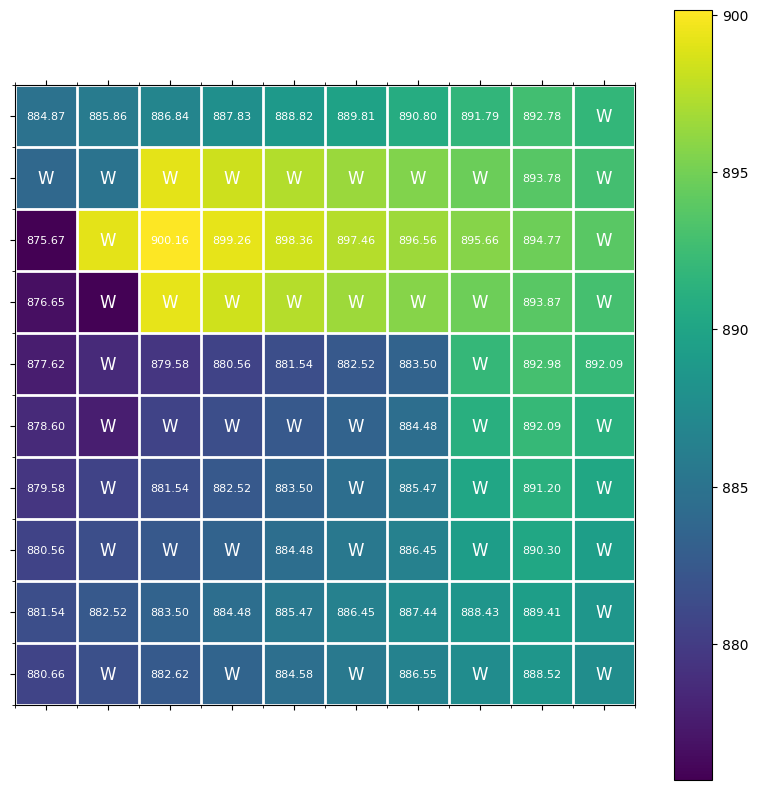

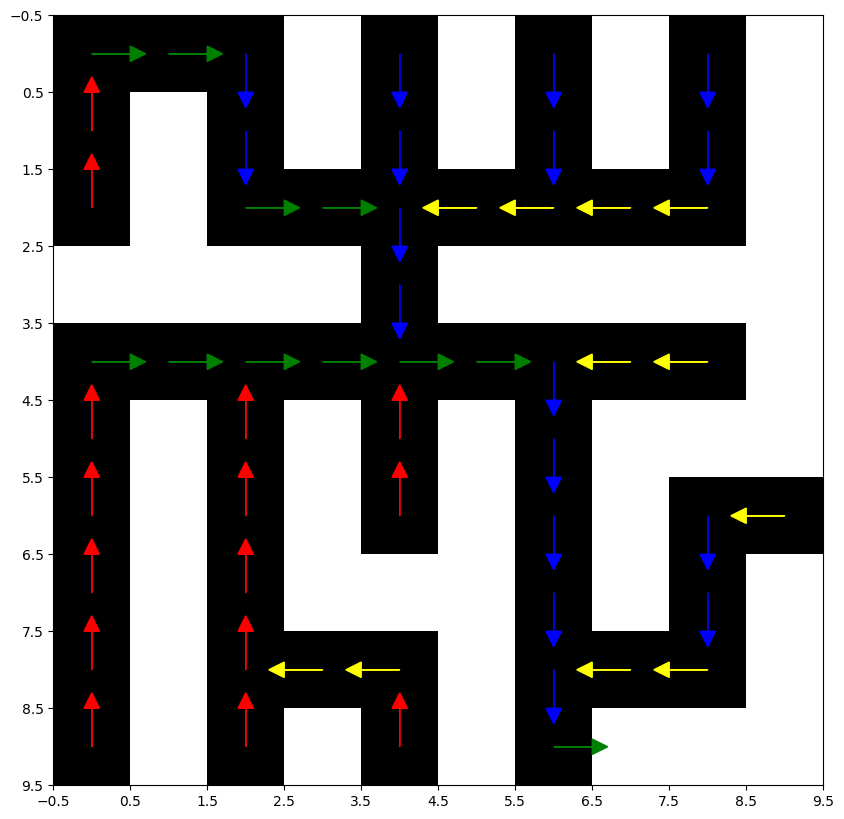

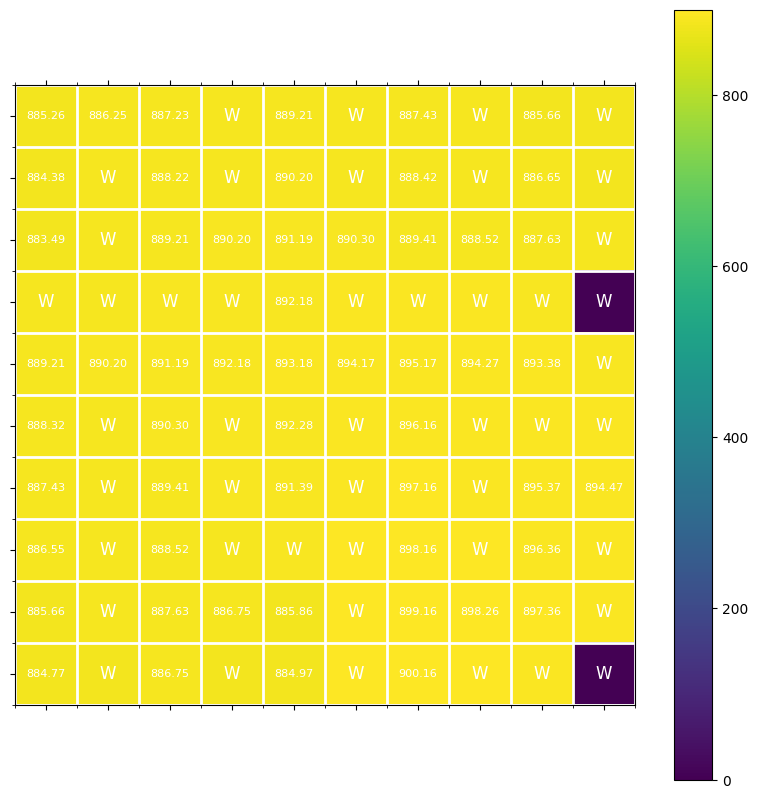

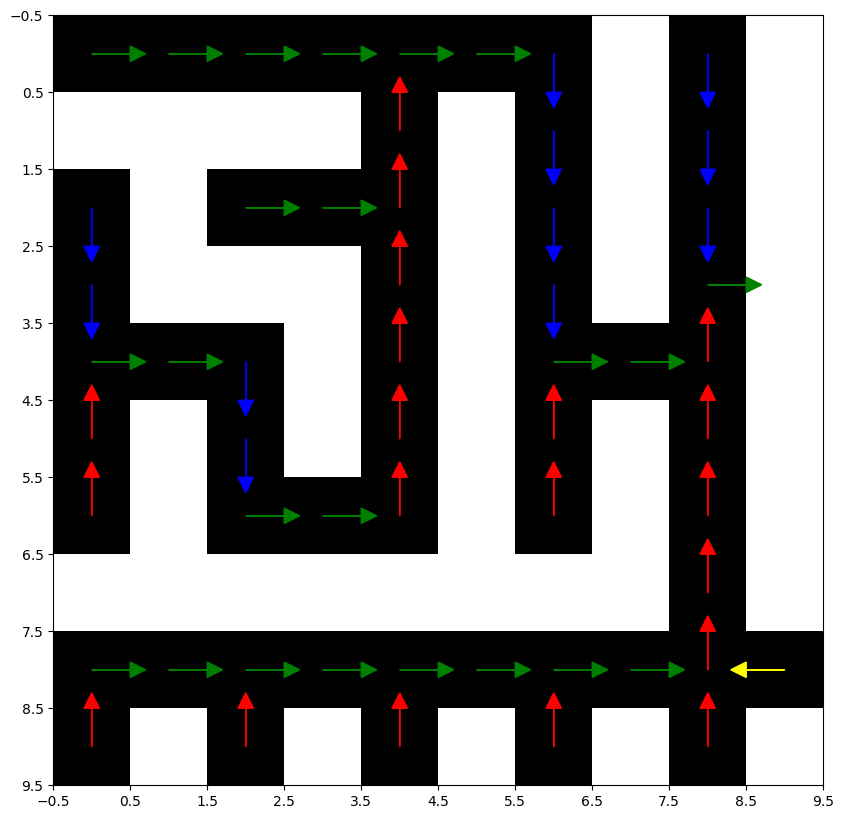

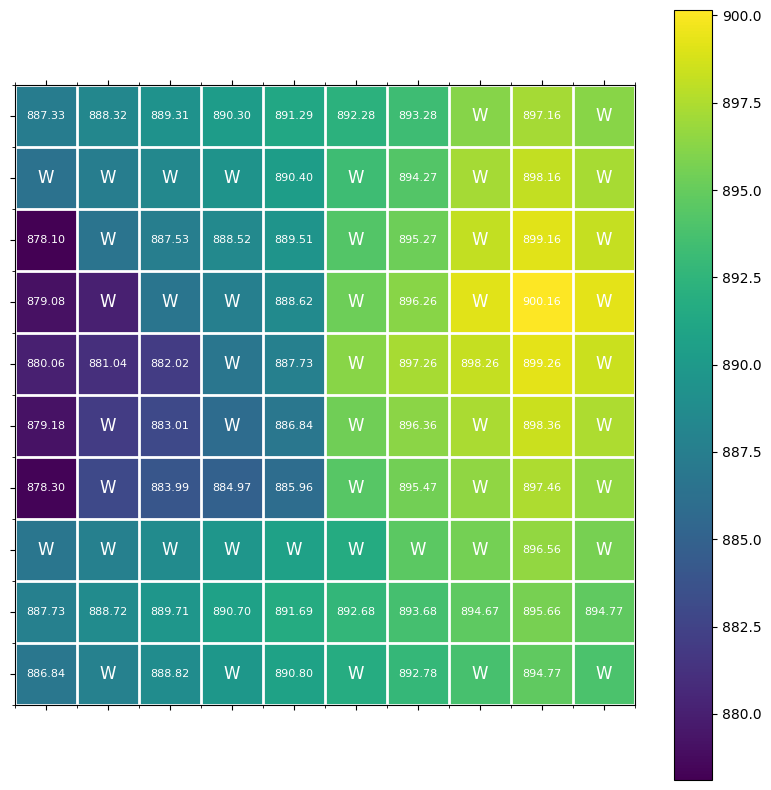

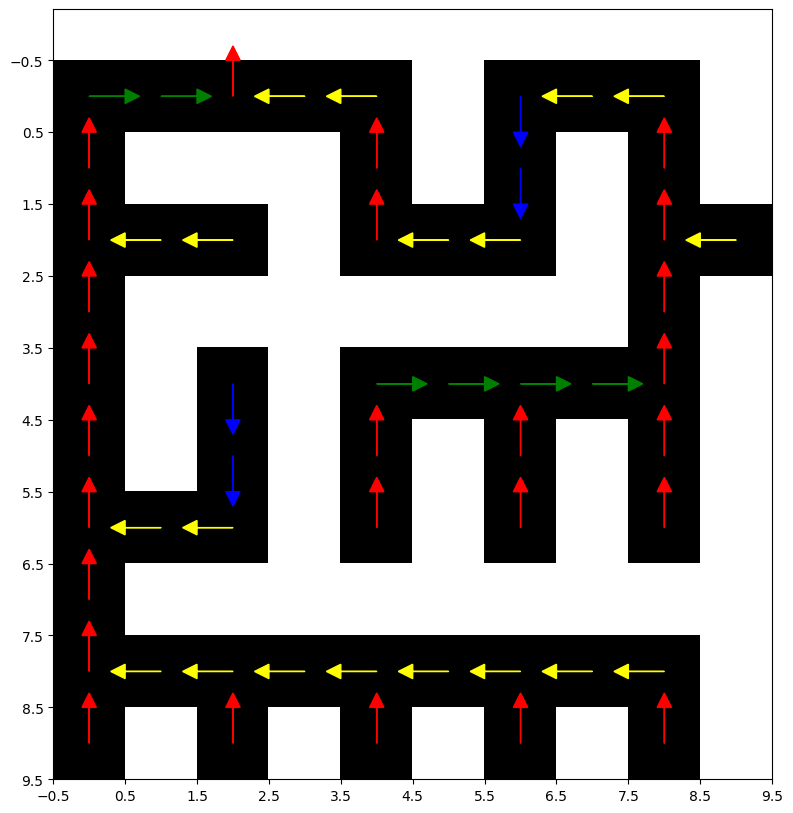

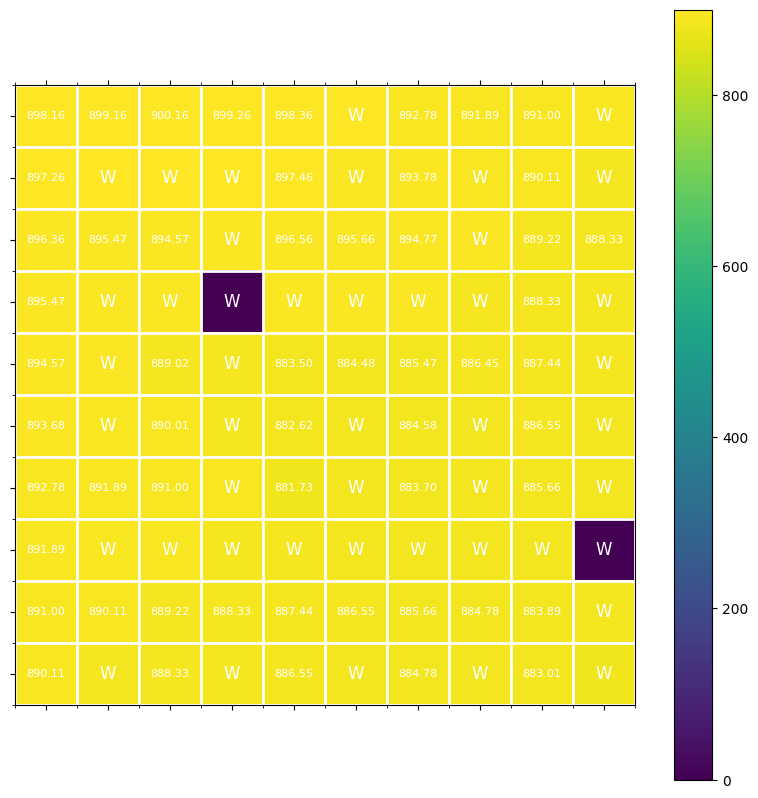

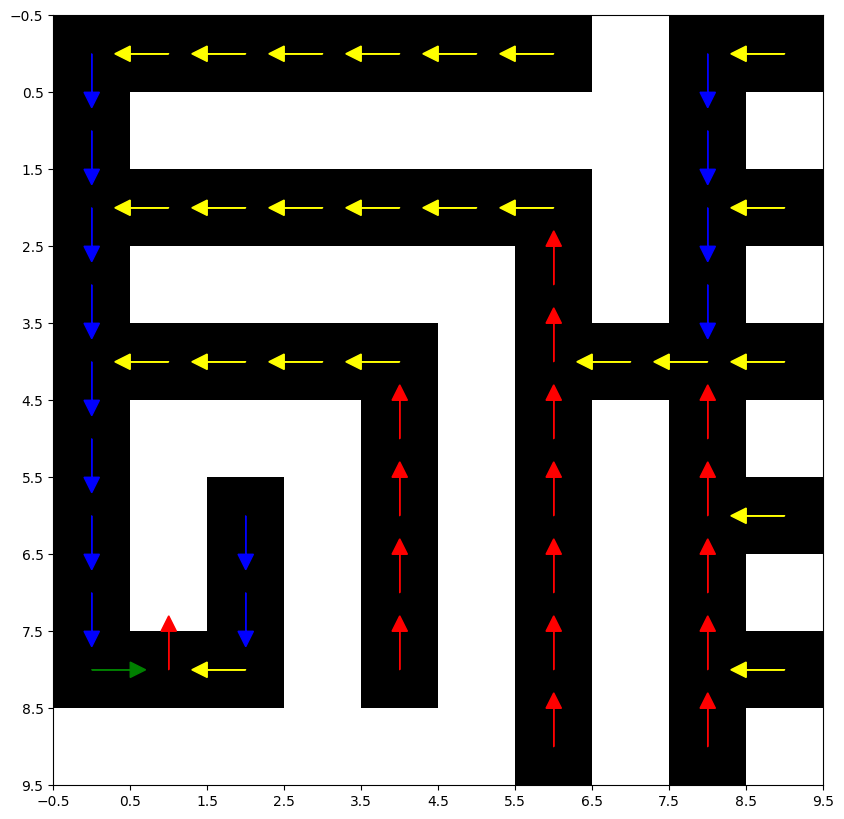

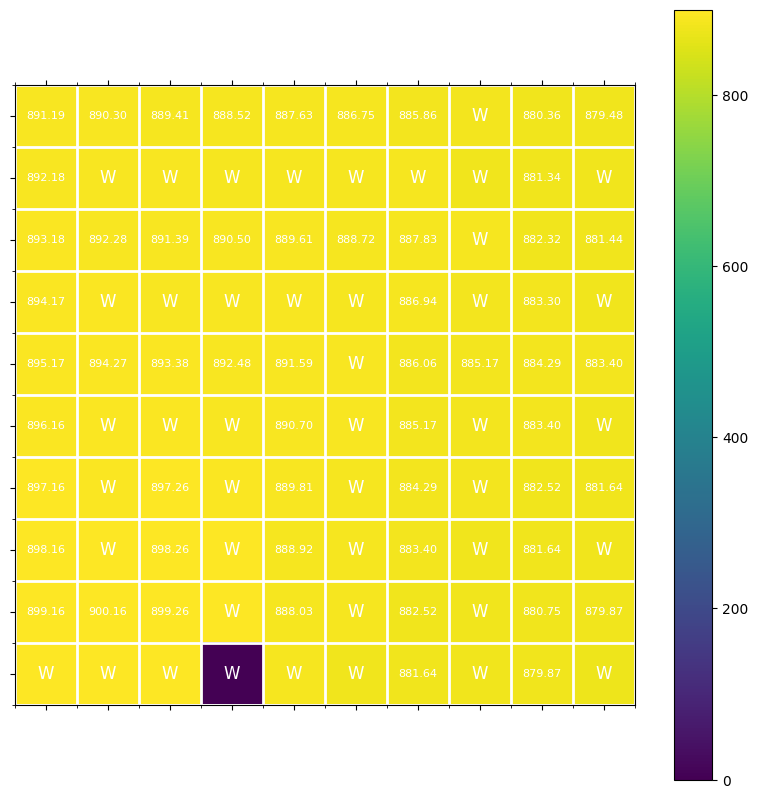

In [278]:
data = []
num_query_states = 10
for k in range(batch_size):
    walls = rollout["whole_timestep"].observation.walls[k][0]
    target_position = np.array([rollout["whole_timestep"].observation.target_position.row[k][0], rollout["whole_timestep"].observation.target_position.col[k][0]])

    P = generate_transition_matrix(walls)
    print(target_position)
    r = generate_reward_function(target_position, walls)
    pi_opt, value = value_iteration(P, r, 0.999, precision=1e-1)

    query_index =  jax.random.choice(random_key, jnp.arange(walls.shape[0] * walls.shape[1]), (num_query_states,), p=~walls.flatten())
    query_states = np.array(index_to_state(query_index, walls.shape[1])).T
    optimal_actions = pi_opt[:, query_index].T
    plot_policy(policy=pi_opt, grid=walls, title=f"policies/pol_{k}")
    plot_value_function(value, walls, f"policies/value_{k}")

    data.append(
        {
        "query_states": query_states,
        "optimal_actions": optimal_actions,
        "context_actions": np.array(rollout["action"][k]),
        "context_states": np.array(jnp.vstack((rollout["state"][0].row[k], rollout["state"][0].col[k]))).T,
        "context_next_states": np.array(jnp.vstack((rollout["next_state"][0].row[k], rollout["next_state"][0].col[k]))).T,
        "context_rewards": np.array(rollout["reward"][k]),
        "goal_state": target_position,
        "env_key": keys_init[k],
        "rollout_key": keys_rollout[k],
        }
    )


In [231]:
data[1]["context_actions"]

array([1, 0, 1, 3, 2, 1, 1, 1, 3, 3, 3, 0, 1, 2, 2, 3, 0, 0, 3, 2],
      dtype=int32)

In [232]:
state.target_position.row

Array([1, 1, 1, 1, 1], dtype=int32)

In [233]:
one_hot = np.zeros((rollout_length,4))
one_hot[np.arange(rollout_length), data[1]["context_actions"]] = 1
# for i in range(batch_size): one_hot[i,data[1]["context_actions"][i]] = 1
one_hot

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]])

In [234]:
data[0]

{'query_states': array([[2, 0],
        [6, 7],
        [8, 4],
        [4, 5],
        [6, 0],
        [6, 7],
        [1, 4],
        [0, 2],
        [6, 4],
        [4, 5]], dtype=int32),
 'optimal_actions': array([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]]),
 'context_actions': array([3, 2, 2, 3, 1, 3, 0, 1, 2, 1, 3, 1, 1, 1, 0, 3, 3, 3, 0, 0],
       dtype=int32),
 'context_states': array([[9, 0],
        [0, 9],
        [6, 9],
        [0, 5],
        [4, 5],
        [6, 5],
        [1, 8],
        [4, 9],
        [6, 7],
        [1, 2],
        [4, 8],
        [5, 0],
        [2, 1],
        [8, 2],
        [2, 4],
        [5, 8],
        [8, 6],
        [8, 9],
        [4, 2],
        [4, 4]], dtype=int32),
 'context_next_states': array([[9, 0],
        [0, 9],
        [6,

In [235]:
data[0]["context_states"], data[0]["context_next_states"]

(array([[9, 0],
        [0, 9],
        [6, 9],
        [0, 5],
        [4, 5],
        [6, 5],
        [1, 8],
        [4, 9],
        [6, 7],
        [1, 2],
        [4, 8],
        [5, 0],
        [2, 1],
        [8, 2],
        [2, 4],
        [5, 8],
        [8, 6],
        [8, 9],
        [4, 2],
        [4, 4]], dtype=int32),
 array([[9, 0],
        [0, 9],
        [6, 9],
        [0, 4],
        [4, 6],
        [6, 4],
        [0, 8],
        [4, 9],
        [6, 7],
        [1, 2],
        [4, 8],
        [5, 0],
        [2, 2],
        [8, 2],
        [1, 4],
        [5, 8],
        [8, 6],
        [8, 8],
        [3, 2],
        [3, 4]], dtype=int32))

In [236]:
state

State(agent_position=Position(row=Array([0, 0, 0, 0, 0], dtype=int32), col=Array([5, 5, 5, 5, 5], dtype=int32)), target_position=Position(row=Array([1, 1, 1, 1, 1], dtype=int32), col=Array([8, 8, 8, 8, 8], dtype=int32)), walls=Array([[[False, False, False,  True, False, False, False, False, False,
         False],
        [ True,  True, False,  True, False,  True, False,  True, False,
          True],
        [False, False, False,  True, False,  True, False,  True, False,
          True],
        [False,  True, False,  True, False,  True,  True,  True,  True,
          True],
        [False,  True, False,  True, False, False, False,  True, False,
         False],
        [False,  True,  True,  True, False,  True,  True,  True, False,
          True],
        [False, False, False, False, False, False, False, False, False,
         False],
        [False,  True,  True,  True, False,  True, False,  True, False,
          True],
        [False, False, False,  True, False,  True, False,  Tr

In [237]:
state.action_mask

Array([[False,  True, False,  True],
       [False,  True, False,  True],
       [False,  True, False,  True],
       [False,  True, False,  True],
       [False,  True, False,  True]], dtype=bool)

In [349]:
x = jnp.zeros(100).reshape(10,10)
y = jnp.ones(9).reshape(3,3)


print(x)
print(y)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]


In [353]:
jax.lax.dynamic_update_slice(x, y, (3,3))


Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [357]:
data[0]["context_actions"]

array([3, 2, 2, 3, 1, 3, 0, 1, 2, 1, 3, 1, 1, 1, 0, 3, 3, 3, 0, 0],
      dtype=int32)

In [363]:
rows = 10
cols = 10
target_row = 0
target_col = 0
cov_size = 3
coverage_mask = jnp.zeros((rows + 2 * cov_size, cols + 2 * cov_size), dtype=bool)
print(coverage_mask)
updates = jnp.ones((1 + 2 * cov_size, 1 + 2 * cov_size), dtype=bool)
coverage_mask = jax.lax.dynamic_update_slice(
                                            coverage_mask, 
                                            updates,
                                            (target_row, target_col)
                                            )
print(coverage_mask)
coverage_mask = jax.lax.slice(coverage_mask, (cov_size,cov_size), (rows+cov_size,cols+cov_size))
mask = ~(coverage_mask | state.walls)

[[False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False Fal

In [370]:
import itertools

In [406]:
actions = [
    [1, 0, 0, 0],  # Up
    [0, 1, 0, 0],  # Down
    [0, 0, 1, 0],  # Left
    [0, 0, 0, 1]   # Right
]

# Generate all permutations of the actions
permutations_list = list(itertools.permutations(actions))
permutations_array = np.array(permutations_list)

test_permutations = []
train_permutations = []

test_permutation = np.array([actions])

for i in range(len(permutations_list)):
    if np.all(~np.all(test_permutation == permutations_array[i], axis=1)):
        train_permutations.append(permutations_array[i])

print(len(test_permutation))



1


In [408]:
permutations_list = list(permutations(actions))
permutations_array = np.array(permutations_list)

test_permutations = []
train_permutations = []

test_permutation = np.array([actions])

for i in range(len(permutations_list)):
    if np.all(~np.all(test_permutation == permutations_array[i], axis=1)):
        train_permutations.append(permutations_array[i])

train_permutations = np.array(train_permutations)

In [411]:
print(len(test_permutation))
print(len(train_permutations))

1
9
